# 1 - Using Random Forest for Salary Prediction
The goal of this project is to use [Stack Overflow user survey data](https://insights.stackoverflow.com/survey/?utm_source=so-owned&utm_medium=blog&utm_campaign=dev-survey-2017&utm_content=blog-link&utm_term=data) to predict salaries.  Specifically, I will be using the responses and self reported salaries from the 2017 dataset to try and predict salaries for the responses in the 2018 dataset.  

For an in depth look at how I pre-processed the data, check out my notebook [here](https://github.com/yscyang1/Predicting_Salaries_SO/blob/master/Pre-Processing%20Data.ipynb). But briefly, what I did was identify matching questions in 2017 and 2018 and isolated those responses.  I then had to make sure that the answers between the two years were the same.  For example, for the same question, in 2017 the answers could be based on a disagree strongly to agree strongly scale, whereas in 2018 the answers could be on a 1-10 scale.  

This notebook is focused on applying random forests to the data.  

### 1.1 - Importing Libraries and Data
I had saved the pre-processed data in feather format, so to load it, you can simply use pandas's read_feather() function.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
df_2017 = pd.read_feather('tmp/df_2017_2keep')
df_2018 = pd.read_feather('tmp/df_2018_2keep')

While saving in feather format, an extra index column is saved.  There doesn't seem to be an 'index = False' argument like saving to csv format does, so I need to drop the index column now.

In [3]:
df_2017.drop(['index'], axis = 1, inplace=True)
df_2018.drop(['index'], axis = 1, inplace=True)

In [4]:
pd.set_option('display.max_columns', 70)

#### 1.1.1 - 2017 Data
While looking at the data, I check to see that mins, means and maxes look reasonable and that datatypes are categorial or numeric.  

In [5]:
df_2017.head()

,ID,Hobby,Country,Student,Employment,Education,UndergradMajor,CompanySize,YearsCoding,YearsCodingProf,DevType,CareerSatisfaction,JobSatisfaction,KinshipDevelopers,CompetePeers,LastNewJob,AssessJobIndustry,AssessJobDept,AssessJobTech,AssessJobCompensation,AssessJobOffice,AssessJobRemote,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,UpdateCV,Currency,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,LanguageWorkedWith,LanguageDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,IDE,Methodology,VersionControl,CheckInCode,StackOverflowJobs,Gender,EducationParents,Race,SurveyLong,Salary,DevType_Count,EducationTypes_Count,LanguageWorkedWith_Count,LanguageDesireNextYear_Count,FrameworkWorkedWith_Count,FrameworkDesireNextYear_Count,DatabaseWorkedWith_Count,DatabaseDesireNextYear_Count,PlatformWorkedWith_Count,PlatformDesireNextYear_Count,IDE_Count,Methodology_Count,VersionControl_Count,Gender_Count,Race_Count
0,3.0,Yes,United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"10,000 or more employees",20 or more years,20 or more years,Other,Moderately satisfied,Moderately satisfied,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,British pounds sterling (£),Self-taught; Coding competition; Hackathon; Op...,Official documentation; Trade book; Textbook; ...,NaN,Java; PHP; Python,C; Python; Rust,NaN,NaN,MySQL,NaN,NaN,NaN,Sublime Text; Vim; IntelliJ,Agile; Lean; Scrum; Extreme; Pair; Kanban,Mercurial,Multiple times per day,No,Male,A professional degree,White or of European descent,The survey was an appropriate length,113750.0,1,4,3,3,0,0,1,0,0,0,3,6,1,1,1
1,15.0,Yes,United Kingdom,No,Employed full-time,Professional degree,Computer engineering or electrical/electronics...,"5,000 to 9,999 employees",20 or more years,20 or more years,Embedded applications/devices developer,Moderately satisfied,Moderately satisfied,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A recruiter contacted me,British pounds sterling (£),NaN,NaN,NaN,Assembly; C; C++,Assembly; C; C++; Python,NaN,NaN,NaN,NaN,Mac OS,Mac OS,Emacs; Xcode,NaN,Git,Multiple times per day,Yes,Male,High school,White or of European descent,The survey was an appropriate length,100000.0,1,0,3,4,0,0,0,0,1,1,2,0,1,1,1
2,18.0,Yes,United States,"Yes, part-time",Employed full-time,Bachelor's degree,Computer science or software engineering,"1,000 to 4,999 employees",20 or more years,20 or more years,Web developer; Embedded applications/devices d...,Moderately satisfied,Moderately satisfied,4.0,1.0,More than 4 years ago,Important,Very important,Very important,Important,Important,Very important,Important,Somewhat important,Important,Somewhat important,NaN,U.S. dollars ($),On-the-job training; Self-taught; Coding compe...,Official documentation; Stack Overflow Q&A; Other,NaN,C; Clojure; JavaScript; Matlab; Rust; SQL; Swift,Assembly; Clojure; Go; JavaScript; Rust; Swift...,React,React; .NET Core,MySQL; PostgreSQL; Oracle,NaN,Linux Desktop; Amazon Web Services (AWS),Android; iOS; Linux Desktop; Arduino; Serverle...,Emacs; Vim,NaN,NaN,NaN,Yes,Male,A master's degree,"Native American, Pacific Islander, or Indigeno...",The survey was too short,130000.0,5,4,7,7,1,2,3,0,2,6,2,0,0,1,2
3,23.0,No,Israel,No,Employed full-time,Bachelor's degree,Computer engineering or electrical/electronics...,500 to 999 employees,9-11 years,6-8 years,Other,Moderately satisfied,Moderately satisfied,0.0,0.0,Less than a year ago,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U.S. dollars ($),Self-taught,Official documentation; Stack Overflow Q&A; No...,NaN,Java,Java; Scala; Swift,Hadoop; Spark,Spark,Cassandra; MySQL,MongoDB,NaN,NaN,Atom; Vim; IntelliJ,Waterfall; Scrum; Kanban,Git,Multiple times per day,No,Male,A bachelor's degree,White or of European descent,The survey was too long,100764.0,1,1,1,3,2,1,2,1,0,0,3,3,1,1,1
4,26.0,Yes,United States,No,Employed full-time,Master's 

In [6]:
df_2017.describe()

,ID,KinshipDevelopers,CompetePeers,Salary,DevType_Count,EducationTypes_Count,LanguageWorkedWith_Count,LanguageDesireNextYear_Count,FrameworkWorkedWith_Count,FrameworkDesireNextYear_Count,DatabaseWorkedWith_Count,DatabaseDesireNextYear_Count,PlatformWorkedWith_Count,PlatformDesireNextYear_Count,IDE_Count,Methodology_Count,VersionControl_Count,Gender_Count,Race_Count
count,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.00000
mean,26234.068359,2.514273,1.916536,58447.683594,2.070409,2.209312,3.626197,3.357702,1.078677,1.545344,1.650827,1.454569,1.762141,2.005396,2.657006,2.157528,0.703220,1.012794,0.95866
std,15869.939453,1.802172,1.553435,39757.484375,1.375717,1.902845,2.085882,2.268431,1.201331,1.493913,1.285074,1.356756,1.610224,1.789411,1.511417,2.085910,0.456859,0.142445,0.39310
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
25%,12163.750000,0.000000,0.000000,30000.000000,1.000000,0.000000,2.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.00000
50%,26233.500000,3.000000,2.000000,52000.000000,2.000000,2.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.00000
75%,41552.500000,4.000000,3.000000,81250.000000,3.000000,4.000000,5.000000,5.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,4.000000,1.000000,1.000000,1.00000
max,51391.000000,5.000000,5.000000,197000.000000,13.000000,9.000000,19.000000,35.000000,9.000000,9.000000,8.000000,8.000000,15.000000,12.000000,18.000000,11.000000,1.000000,5.000000,9.00000


In [7]:
df_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11490 entries, 0 to 11489
Data columns (total 64 columns):
ID                               11490 non-null float32
Hobby                            11490 non-null category
Country                          11490 non-null category
Student                          11490 non-null category
Employment                       11490 non-null category
Education                        11490 non-null category
UndergradMajor                   11490 non-null category
CompanySize                      11490 non-null category
YearsCoding                      11490 non-null category
YearsCodingProf                  11490 non-null category
DevType                          11490 non-null category
CareerSatisfaction               11490 non-null category
JobSatisfaction                  11490 non-null category
KinshipDevelopers                11490 non-null float32
CompetePeers                     11490 non-null float32
LastNewJob                       11490 

#### 1.1.2 - 2018 Data




In [8]:
df_2018.describe()

,ID,Salary,KinshipDevelopers,CompetePeers,DevType_Count,EducationTypes_Count,LanguageWorkedWith_Count,LanguageDesireNextYear_Count,FrameworkWorkedWith_Count,FrameworkDesireNextYear_Count,DatabaseWorkedWith_Count,DatabaseDesireNextYear_Count,PlatformWorkedWith_Count,PlatformDesireNextYear_Count,IDE_Count,Methodology_Count,VersionControl_Count,Gender_Count,Race_Count
count,37609.000000,3.760900e+04,37609.000000,37609.000000,37609.000000,37609.000000,37609.000000,37609.000000,37609.000000,37609.000000,37609.000000,37609.000000,37609.000000,37609.000000,37609.000000,37609.000000,37609.000000,37609.000000,37609.000000
mean,50885.632812,1.036810e+05,3.735037,2.782259,2.937276,3.057938,6.128985,4.810923,1.443910,1.848972,2.452764,2.306230,2.380361,2.695498,2.819192,2.300620,1.331437,1.009785,0.916935
std,29317.384766,2.127195e+05,1.007572,1.221405,2.011646,1.603837,3.065431,3.118760,1.366341,1.681371,1.986288,2.307225,2.023185,2.495224,1.621100,1.645848,0.686145,0.114657,0.419508
min,3.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,25482.000000,3.176400e+04,3.000000,2.000000,1.000000,2.000000,4.000000,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
50%,51025.000000,6.100000e+04,4.000000,3.000000,3.000000,3.000000,6.000000,5.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000
75%,76173.000000,9.662600e+04,4.000000,4.000000,4.000000,4.000000,8.000000,7.000000,2.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,3.000000,2.000000,1.000000,1.000000
max,101592.000000,2.000000e+06,5.000000,5.000000,20.000000,9.000000,38.000000,38.000000,12.000000,12.000000,19.000000,21.000000,19.000000,26.000000,22.000000,10.000000,7.000000,4.000000,7.000000


In [9]:
df_2018.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37609 entries, 0 to 37608
Data columns (total 64 columns):
ID                               37609 non-null float32
Hobby                            37609 non-null category
Country                          37609 non-null category
Student                          37609 non-null category
Employment                       37609 non-null category
Education                        37609 non-null category
UndergradMajor                   37609 non-null category
CompanySize                      37609 non-null category
DevType                          37609 non-null category
YearsCoding                      37609 non-null category
YearsCodingProf                  37609 non-null category
JobSatisfaction                  37609 non-null category
CareerSatisfaction               37609 non-null category
LastNewJob                       37609 non-null category
AssessJobIndustry                37609 non-null category
AssessJobFinances                3760

#### 1.1.3 - Minimum Salary
A big problem I'm noticing in both 2017 and 2018 datasets is that min salaries is 0.  That doesn't sound right, because I filtered responses to everyone who is full or part time employed and input a salary.  

Only 3 with salary of 0 in 2017, but ~100 of them in 2018.  

In [10]:
df_2017[df_2017['Salary']==0]

,ID,Hobby,Country,Student,Employment,Education,UndergradMajor,CompanySize,YearsCoding,YearsCodingProf,DevType,CareerSatisfaction,JobSatisfaction,KinshipDevelopers,CompetePeers,LastNewJob,AssessJobIndustry,AssessJobDept,AssessJobTech,AssessJobCompensation,AssessJobOffice,AssessJobRemote,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,AssessJobFinances,UpdateCV,Currency,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,LanguageWorkedWith,LanguageDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,IDE,Methodology,VersionControl,CheckInCode,StackOverflowJobs,Gender,EducationParents,Race,SurveyLong,Salary,DevType_Count,EducationTypes_Count,LanguageWorkedWith_Count,LanguageDesireNextYear_Count,FrameworkWorkedWith_Count,FrameworkDesireNextYear_Count,DatabaseWorkedWith_Count,DatabaseDesireNextYear_Count,PlatformWorkedWith_Count,PlatformDesireNextYear_Count,IDE_Count,Methodology_Count,VersionControl_Count,Gender_Count,Race_Count
5312,23908.0,Yes,Sweden,No,Employed full-time,Secondary school,NaN,Fewer than 10 employees,3-5 years,3-5 years,Web developer,Slightly satisfied,Slightly satisfied,0.0,0.0,Less than a year ago,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I was just giving it a regular update,Swedish kroner (SEK),Online course; On-the-job training; Self-taugh...,Official documentation; Stack Overflow Q&A; No...,NaN,JavaScript,C++; JavaScript; Python,Node.js; React,Node.js; React,NaN,NaN,Microsoft Azure,Microsoft Azure,Atom; Sublime Text,Waterfall; Agile; Scrum; Extreme; Pair,Git,Multiple times per day,No,Male,A bachelor's degree,White or of European descent,The survey was too short,0.0,1,4,1,3,2,2,0,0,1,1,2,5,1,1,1
9590,44842.0,Yes,Japan,No,Employed full-time,Bachelor's degree,A social science,100 to 499 employees,0-2 years,0-2 years,DevOps specialist; Quality assurance engineer,Moderately satisfied,Moderately satisfied,3.0,3.0,Not applicable/ never,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Japanese yen (¥),Online course; Part-time/evening course; On-th...,NaN,NaN,CoffeeScript; Groovy; Java; JavaScript; Ruby,Groovy; Java; JavaScript; Python; Ruby; SQL; T...,Node.js,AngularJS; Hadoop; Node.js; Spark,Redis; MySQL; SQLite,MongoDB,Android; iOS; Linux Desktop; Mac OS; Raspberry...,Android; iOS; Linux Desktop; Mac OS; Raspberry...,Atom; Vim; IntelliJ,Agile; Kanban,Git,Once a day,Yes,Female,A bachelor's degree,East Asian,The survey was too long,0.0,2,3,5,7,1,4,3,1,6,6,3,2,1,1,1
11437,51145.0,Yes,Australia,No,Employed full-time,Bachelor's degree,Fine arts or performing arts,10 to 19 employees,20 or more years,18-20 years,Web developer,Neither satisfied nor dissatisfied,Slightly dissatisfied,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I was just giving it a regular update,Australian dollars (A$),Part-time/evening course; Self-taught,Official documentation; Trade book; Stack Over...,NaN,JavaScript; PHP,JavaScript; PHP; Python,NaN,NaN,MySQL,MySQL,Amazon Web Services (AWS); Microsoft Azure,Arduino; Amazon Web Services (AWS); Microsoft ...,Sublime Text,Agile; Scrum; Kanban,Git,Multiple times per day,No,Male,A bachelor's degree,White or of European descent,The survey was too long,0.0,1,2,2,3,0,0,1,1,2,3,1,3,1,1,1


In [11]:
df_2018[df_2018['Salary']==0].head()

,ID,Hobby,Country,Student,Employment,Education,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,JobSatisfaction,CareerSatisfaction,LastNewJob,AssessJobIndustry,AssessJobFinances,AssessJobDept,AssessJobTech,AssessJobCompensation,AssessJobOffice,AssessJobRemote,AssessJobProfDevel,AssessJobDiversity,AssessJobProduct,UpdateCV,Currency,Salary,EducationTypes,SelfTaughtTypes,TimeAfterBootcamp,KinshipDevelopers,CompetePeers,LanguageWorkedWith,LanguageDesireNextYear,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,FrameworkWorkedWith,FrameworkDesireNextYear,IDE,Methodology,VersionControl,CheckInCode,StackOverflowJobs,Gender,EducationParents,Race,SurveyLong,DevType_Count,EducationTypes_Count,LanguageWorkedWith_Count,LanguageDesireNextYear_Count,FrameworkWorkedWith_Count,FrameworkDesireNextYear_Count,DatabaseWorkedWith_Count,DatabaseDesireNextYear_Count,PlatformWorkedWith_Count,PlatformDesireNextYear_Count,IDE_Count,Methodology_Count,VersionControl_Count,Gender_Count,Race_Count
5,21.0,No,Netherlands,"Yes, full-time",Employed full-time,"Secondary school (e.g. American high school, G...",NaN,20 to 99 employees,Back-end developer;Front-end developer;Student,0-2 years,0-2 years,Neither satisfied nor dissatisfied,Moderately dissatisfied,Between 2 and 4 years ago,Not at all important,Very important,Not at all important,Very important,Somewhat important,Not very important,Not very important,Somewhat important,Important,Important,My job status or other personal status changed,Euros (€),0.0,Received on-the-job training in software devel...,NaN,NaN,2.0,1.0,Java;JavaScript;PHP;VB.NET;HTML;CSS,NaN,SQL Server;MySQL,NaN,Windows Desktop or Server,NaN,NaN,NaN,Notepad++;Visual Studio,Agile;Scrum,Copying and pasting files to network shares,Never,No,Male,Associate degree,White or of European descent,The survey was an appropriate length,3,1,6,0,0,0,2,0,1,0,2,2,1,1,1
248,693.0,Yes,India,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Information systems, information technology, o...",20 to 99 employees,Back-end developer,0-2 years,0-2 years,Moderately satisfied,Moderately satisfied,Less than a year ago,Important,Important,Somewhat important,Very important,Somewhat important,Not very important,Not at all important,Not very important,Very important,Not at all important,My job status or other personal status changed,Indian rupees (₹),0.0,Taken an online course in programming or softw...,The official documentation and/or standards fo...,NaN,3.0,3.0,JavaScript;PHP;SQL;HTML;CSS,JavaScript;Python;SQL;TypeScript;Kotlin;HTML;CSS,MySQL,MongoDB;MySQL;SQLite;MariaDB,NaN,NaN,NaN,Angular;Django;Node.js,IPython / Jupyter;Sublime Text,NaN,I don't use version control,NaN,No,Male,Primary/elementary school,NaN,The survey was too long,1,2,5,7,0,3,1,4,0,0,2,0,1,1,0
923,2547.0,Yes,Switzerland,"Yes, full-time",Employed full-time,I prefer not to answer,NaN,"1,000 to 4,999 employees",Back-end developer;Desktop or enterprise appli...,3-5 years,3-5 years,Moderately satisfied,Slightly dissatisfied,Between 1 and 2 years ago,Important,Important,Somewhat important,Very important,Not at all important,Not at all important,Very important,Somewhat important,Not very important,Not very important,NaN,Swiss francs,0.0,Taken an online course in programming or softw...,The official documentation and/or standards fo...,NaN,3.0,5.0,C#;Java;JavaScript;PHP;Python;SQL;HTML;CSS;Bas...,C#;F#;SQL,SQL Server;MySQL;SQLite;MariaDB,MongoDB;SQLite;MariaDB,Android;Linux;Mac OS;Raspberry Pi;Windows Desk...,Linux;Mac OS;Windows Desktop or Server,.NET Core;Node.js;Xamarin,.NET Core,Notepad++;Visual Studio,NaN,Git;Team Foundation Version Control,A few times per week,Yes,Male,A professional degree,White or of European descent,The survey was too long,5,3,9,3,3,1,4,3,6,3,2,0,2,1,1
1002,2745.0,No,India,"Yes, full-time",Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",500 to 999 employees,D

In [12]:
len(df_2018[df_2018['Salary']==0])

104

For the most part, having a salary of $0 doesn't make sense, so I will drop these people.  

In [13]:
df_2017 = df_2017[df_2017['Salary'] != 0]
df_2018 = df_2018[df_2018['Salary'] != 0]

In [14]:
df_2017 = df_2017.reset_index(drop = True)
df_2018 = df_2018.reset_index(drop = True)

#### 1.1.4 - Maximum Salary
For 2017, the maximum salary is ~200k, which is reasonable.  However, for 2018, the maximum is 2 million, which seems far too high.  Before adjusting the 2018 max, I want to get a base result so I know how the adjustments affect my random forest results.  

Adjustment of salaries can be found [here](https://github.com/yscyang1/Predicting_Salaries_SO/blob/master/Pre-Processing%20Salaries.ipynb).

# 2 - Applying Random Forest Regressor

### 2.1 - Numericalize Data
Before I can put the data into a random forest regressor, the categorical columns must be numericalized.  This can be done by utilizing the codes portion of each category, where each unique answer to a column is given a unique numerical value.  I apply a numericalizing function to a combined dataframe of both 2017 and 2018 so that the same codes are applied to both years.

In [15]:
def numericalize_col(df):
    for col in df.select_dtypes(['object']):
        df[col] = df[col].astype('category')
    for col in df.select_dtypes(['category']):
        df[col] = df[col].cat.codes


In [16]:
combined = pd.concat([df_2017, df_2018])

In [17]:
numericalize_col(combined)

In [18]:
# Separate the combined dataframes
df_2017_keep = combined.iloc[:11487]
df_2018_keep = combined.iloc[11487:]

Now, we see that all columns have a numerical value.   

In [19]:
df_2017_keep.head()

,AssessJobCompensation,AssessJobDept,AssessJobDiversity,AssessJobFinances,AssessJobIndustry,AssessJobOffice,AssessJobProduct,AssessJobProfDevel,AssessJobRemote,AssessJobTech,CareerSatisfaction,CheckInCode,CompanySize,CompetePeers,Country,Currency,DatabaseDesireNextYear,DatabaseDesireNextYear_Count,DatabaseWorkedWith,DatabaseWorkedWith_Count,DevType,DevType_Count,Education,EducationParents,EducationTypes,EducationTypes_Count,Employment,FrameworkDesireNextYear,FrameworkDesireNextYear_Count,FrameworkWorkedWith,FrameworkWorkedWith_Count,Gender,Gender_Count,Hobby,ID,IDE,IDE_Count,JobSatisfaction,KinshipDevelopers,LanguageDesireNextYear,LanguageDesireNextYear_Count,LanguageWorkedWith,LanguageWorkedWith_Count,LastNewJob,Methodology,Methodology_Count,PlatformDesireNextYear,PlatformDesireNextYear_Count,PlatformWorkedWith,PlatformWorkedWith_Count,Race,Race_Count,Salary,SelfTaughtTypes,StackOverflowJobs,Student,SurveyLong,TimeAfterBootcamp,UndergradMajor,UpdateCV,VersionControl,VersionControl_Count,YearsCoding,YearsCodingProf
0,1,1,1,1,1,1,1,1,1,1,3,2,2,2.0,158,3,4404,0,2676,1,5047,1,1,3,505,4,0,1373,0,792,0,14,1,1,3.0,6529,3,3,3.0,8814,3,15063,3,4,68,6,8411,0,6089,0,103,1,113750.0,544,1,1,1,7,14,12,48,1,4,4
1,1,1,1,1,1,1,1,1,1,1,3,2,5,3.0,158,3,4404,0,3084,0,4690,1,10,5,132,0,0,1373,0,792,0,14,1,1,15.0,4411,2,3,3.0,226,4,79,3,4,594,0,8348,1,6021,1,103,1,100000.0,140,2,1,1,7,12,1,4,1,4,4
2,0,5,4,4,0,0,0,0,5,5,3,3,0,1.0,160,21,4404,0,2680,3,5225,5,1,2,145,4,0,1479,2,875,1,14,1,1,18.0,4373,2,3,4.0,289,7,8391,7,3,594,0,3410,6,5830,2,97,2,130000.0,238,2,3,3,7,14,12,62,0,4,4
3,1,1,1,1,1,1,1,1,1,1,3,2,6,0.0,68,21,1930,1,91,2,5047,1,1,0,502,1,0,1523,1,735,2,14,1,0,23.0,2408,3,3,0.0,17086,3,14866,1,2,846,3,8411,0,6089,0,103,1,100764.0,230,1,1,2,7,12,12,4,1,7,6
4,0,3,0,4,3,0,4,4,0,5,7,3,2,3.0,160,21,192,1,2676,1,5067,1,6,2,132,0,0,1035,2,901,1,14,1,1,26.0,4809,1,7,4.0,18313,2,15121,2,3,594,0,8413,1,6089,0,103,1,175000.0,140,2,1,3,7,14,0,62,0,4,2


### 2.2 - Splitting the Data
Before putting everything into a random forest, I'd like to split my training data (the 2017 data) into a training, validation, and test set.  By test set, I mean a second validation set.  For this project, the traditional test set where I make my final predictions will be called 2018 data.

In [20]:
def get_subset(df, train_percent=.5, validate_percent=.25, copy = True, seed=None):
    if copy:
        df_copy = df.copy()
    perm = np.random.RandomState(seed).permutation(df_copy.index)
    length = len(df_copy.index)
    train_end = int(train_percent * length)
    validate_end = int(validate_percent * length) + train_end
    train = df_copy.iloc[perm[:train_end]]
    validate = df_copy.iloc[perm[train_end:validate_end]]
    test = df_copy.iloc[perm[validate_end:]]
    
    return train.reset_index(drop=True), validate.reset_index(drop=True), test.reset_index(drop=True)

In [21]:
train, val, test = get_subset(df_2017_keep)

In [22]:
# Split training, validation, and test sets into X and y
X_train = train.drop(['Salary'], axis = 1)
X_val = val.drop(['Salary'], axis = 1)
X_test = test.drop(['Salary'], axis = 1)

y_train = train['Salary']
y_val = val['Salary']
y_test = test['Salary']

In [23]:
# Split 2018 data into X and y
X_2018 = df_2018_keep.drop('Salary', axis = 1)
y_2018 = df_2018_keep['Salary']

### 2.3 - Random Forest Regressor
Finally, the data should be ready to input into a random forest.  For this, I will be using sklearn's random forest regressor.  Since I just want a baseline r2 score, I'll use the default values and set n_jobs = -1, which uses all processors available to run the model.  

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [25]:
rf_quick = RandomForestRegressor(n_jobs=-1)
rf_quick.fit(X_train, y_train)

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

Here, I've written a function to print r2 scores for the training and validation set.  We see that the training set has a pretty good score of 0.93, but the validation set is pretty dismal in comparison, only 0.63.  This tells us that the model is overfitting.  

In [26]:
def print_score(model, X_t, y_t, X_v, y_v, oob = False):
    print('Training Score: {}'.format(model.score(X_t, y_t)))
    print('Validation Score: {}'.format(model.score(X_v, y_v)))
    if oob:
        if hasattr(model, 'oob_score_'):
            print("OOB Score:{}".format(model.oob_score_))

In [27]:
print_score(rf_quick, X_train, y_train, X_val, y_val)

Training Score: 0.9341617220392124
Validation Score: 0.6485618924763767


#### 2.3.1 - Predicting 2018 Salaries with rf_quick
Using this random forest model to predict 2018 salaries, I get a negative score!  I knew the model wasn't the greatest considering the small amount of pre-processing I did and the low validation score, but I did not expect it to be this bad.

In [28]:
metrics.r2_score(y_2018, rf_quick.predict(X_2018))

-0.004381405886804135

#### 2.3.2 - Residual Plots
If you plot the predicted vs actual y values in a scatter plot, if the model is good, you'd expect to see a slope of ~1.  Below, I've plotted predicted vs actual salaries for the training, validation, and 2018 data.  

For the training set, there is a general positive linear trend, but its pretty noisy.  Surprisingly, the plot for the validation set looks to be pretty good, and the 2018 data is all over the place.  

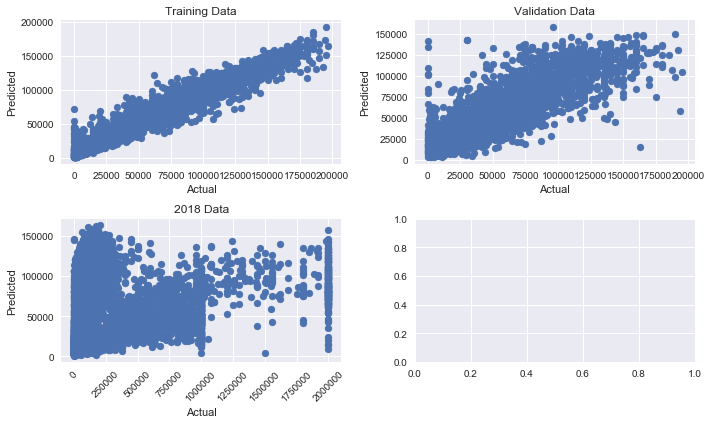

In [29]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2,2,figsize=(10,6))

axis1.scatter(x = y_train, y = rf_quick.predict(X_train))
axis1.set_title('Training Data')
axis1.set_xlabel('Actual')
axis1.set_ylabel('Predicted')

axis2.scatter(x = y_val, y = rf_quick.predict(X_val))
axis2.set_title('Validation Data')
axis2.set_xlabel('Actual')
axis2.set_ylabel('Predicted')

axis3.scatter(x = y_2018, y = rf_quick.predict(X_2018))
axis3.set_title('2018 Data')
axis3.set_xlabel('Actual')
axis3.set_ylabel('Predicted')

for ticks in axis3.get_xticklabels():
    ticks.set_rotation(45)

fig.tight_layout()

Residuals is the difference between the actual and predicted data points.  In essence, the error of the prediction.  A residual plot graphs the difference on the y axis, and the actual data on the x axis.  A good model would show data points evenly and randomly spread above and below y=0.  

In the training set, the differences are higher than actual for salaries less than 100k, but predicts low above than 100k.  

In the validation set, as noted from the scatter plot, there seems to be a good spread around y = 0, but the error values are pretty high.  

The 2018 data is again, terrible looking.  But what both the scatter and residual plots indicate is that I need to adjust those max salaries ASAP.  There is also a sharp division at 1 million dollars.

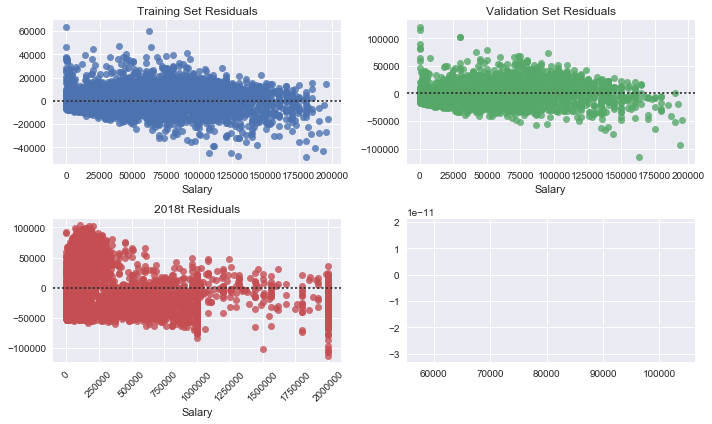

In [30]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2,2,figsize=(10,6))

sns.residplot(x = y_train, y = rf_quick.predict(X_train),ax = axis1)
axis1.set_title('Training Set Residuals')

sns.residplot(x = y_val, y = rf_quick.predict(X_val), ax = axis2)
axis2.set_title('Validation Set Residuals')

sns.residplot(x = y_2018, y = rf_quick.predict(X_2018), ax = axis3)
axis3.set_title('2018 Residuals')

for ticks in axis3.get_xticklabels():
    ticks.set_rotation(45)
    
fig.tight_layout()

### 2.3.3 - Working with Adjusted Salaries
I suspect I'll be repeating the process above for combining and numericalizing datasets and creating a training, validation, and test set quite often, so I wrote a function to automatically do it by taking in the data frames from each year.  

I tested three models concerning salary adjustment.  The first was going through each currency (see the work [here](https://github.com/yscyang1/Predicting_Salaries_SO/blob/master/Pre-Processing%20Salaries.ipynb)) and looking at the histograms.  From there, I was able to see which data points were obviously too high and divided by ten.   This didn't affect the 2017 data too much, so the training and validation score stayed at around 0.93 and 0.62 respectively.  However, the 2018 score improved to ~0.51.  

The second adjustment I made, which includes the adjustment of the max salary described above, was simply rounding the salaries to the nearest thousands place, since that is how we naturally think of salaries.  Training and 2018 score didn't change, but the validation score increased by ~0.02 to 0.64.

The third adjustment was to keep the maximum salary adjustment, but add a minimum salary adjustment.  I encountered blogger Evelina Gabasova's [post](http://evelinag.com/blog/2017/06-20-stackoverflow-tabs-spaces-and-salary/index.html#.XGdd8lxKjIU) concerning the 2017 data.  She noted that some countries had a bimodal distribution, and she suspected that it was because some countries talk about their salaries in terms of montly, not yearly, salary.  Thus, I went through each currency and found those with bimodal distributions in 2017, but not in 2018.  Any 2017 salaries that were too low, I multiplied by 12.  The data was then rounded.  This resulted in slightly higher training and 2018 score; both increased by ~0.01.

A summary of the training, validation, and 2018 scores for each adjustment are tabulated below.

| Score | Adjusted Max Sal   |  Rounded Sal w/ Adj Max | Rounded Sal w/ Adj Min & Max| 
|------|------|
|   Training Score | 0.93 | 0.93 |  0.94  |
| Validation Score | 0.62 | 0.64 |  0.64  |
|   2018 Data      | 0.51 | 0.51 |  0.52  |

In [31]:
df_2017_adj = pd.read_feather('tmp/df_2017_5lower')
df_2018_adj = pd.read_feather('tmp/df_2018_5lower')

In [32]:
def process_df(df2017, df2018):
    # Combine and numericalize two df
    combined = pd.concat([df2017, df2018])
    numericalize_col(combined)
    
    #split combined df
    df2017_split = combined.iloc[:11487]
    df2018_split = combined.iloc[11487:]
    
    # Get test, val, train set
    train, val, test = get_subset(df2017_split)
    
    return df2017_split, df2018_split, train, val, test

In [33]:
df_2017_adjkeep, df_2018_adjkeep, train, val, test = process_df(df_2017_adj, df_2018_adj)

In [34]:
X_train_adj = train.drop(['Salary'], axis = 1)
X_val_adj = val.drop(['Salary'], axis = 1)
X_test_adj = test.drop(['Salary'], axis = 1)

y_train_adj = train['Salary']
y_val_adj = val['Salary']
y_test_adj = test['Salary']

X_2018_adj = df_2018_adjkeep.drop('Salary', axis = 1)
y_2018_adj = df_2018_adjkeep['Salary']

In [35]:
rf_adj = RandomForestRegressor(n_jobs=-1)
rf_adj.fit(X_train_adj, y_train_adj)
print_score(rf_adj, X_train_adj, y_train_adj, X_val_adj, y_val_adj)
print(metrics.r2_score(y_2018_adj, rf_adj.predict(X_2018_adj)))

C:\Users\Crystal\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Training Score: 0.9370484658674031
Validation Score: 0.637605133434514
0.512275187785


The residual plot for 2018 data looks much better than before, but residuals aren't distributed normally over y=0 like it is for the training and validation sets.  Namely, the model is predicting high for salaries less than 125k, and predicting low for salaries above 125k.  

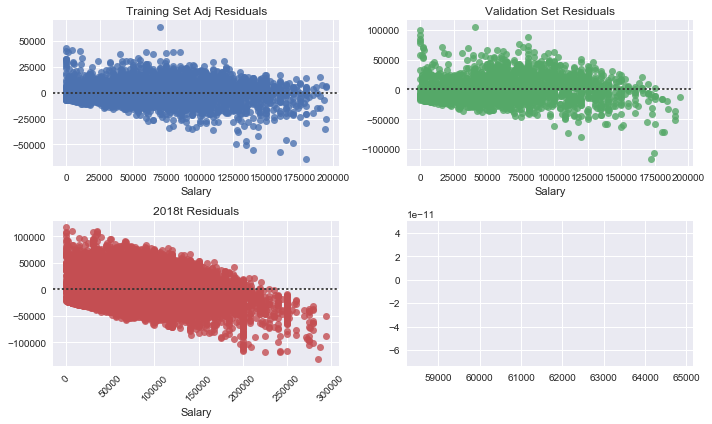

In [38]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2,2,figsize=(10,6))

sns.residplot(x = y_train_adj, y = rf_adj.predict(X_train_adj),ax = axis1)
axis1.set_title('Training Set Adj Residuals')

sns.residplot(x = y_val_adj, y = rf_adj.predict(X_val_adj), ax = axis2)
axis2.set_title('Validation Set Residuals')

sns.residplot(x = y_2018_adj, y = rf_adj.predict(X_2018), ax = axis3)
axis3.set_title('2018t Residuals')

for ticks in axis3.get_xticklabels():
    ticks.set_rotation(45)
    
fig.tight_layout()

### Possible Next Steps
-  Would it help to transform salaries?  Ex: 1/sal, sal^2, sqrt(sal), log(sal)
-  adjust lower threshold of 2017 salaries